# Gradient Boosted model with state and action vectors as input

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../scripts"))

from load_data import load_data

## Load Data
### Start with smaller dataset

In [2]:
df = load_data("03-06-24", "A1.csv")

In [3]:
capacity = df['Capacity/mA.h']
cycle_number = df['cycle number']

### Confirm Degradation

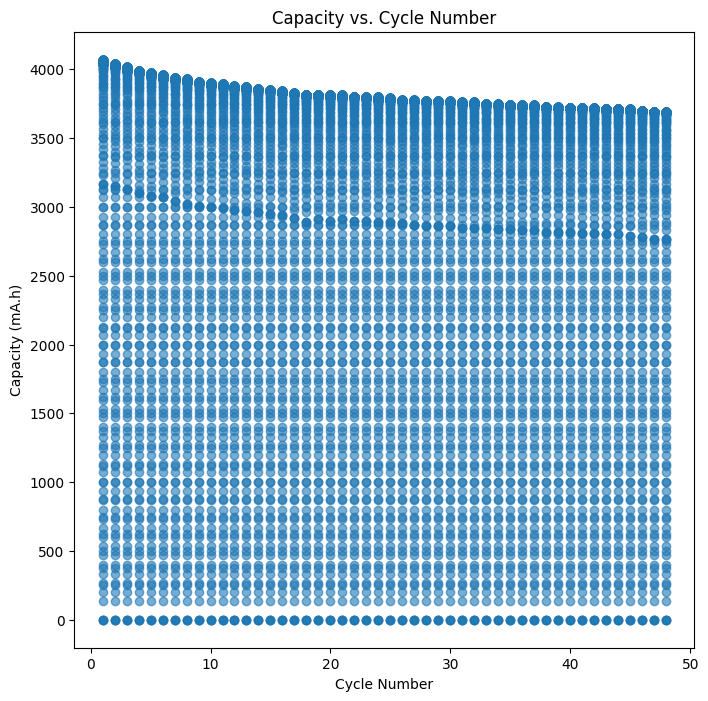

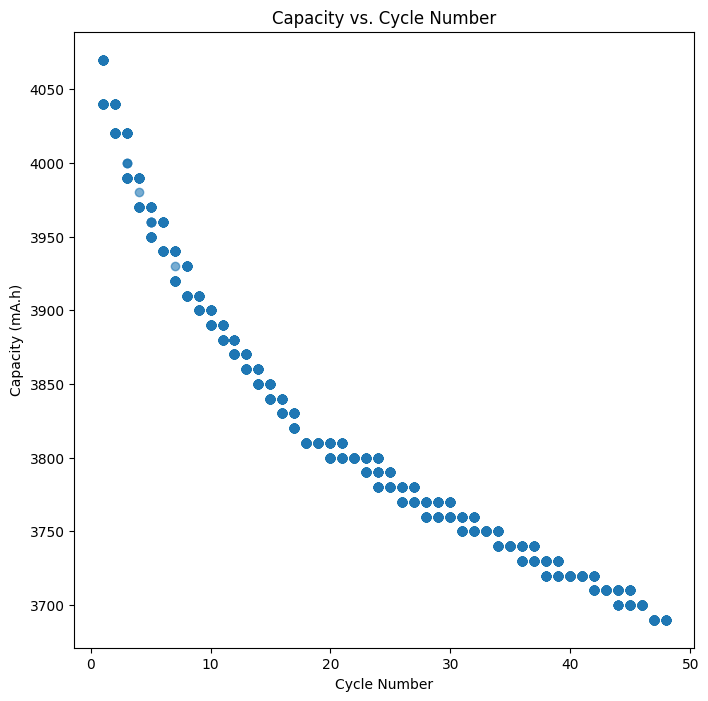

In [3]:
from plot_degradation import plot_degradation

plot_degradation(df)

#### Important note: degradation is not visible unless we filter for just the states that EIS is being performed

## Preprocess

### Building the Input
#### We need a state and action vector

#### State Vector $s_{n}$ - concatenated impedance values at 57 different frequencies 0.02Hz - 20kHz

In [6]:
df['freq/Hz'].min()

np.float64(0.0)

In [7]:
df['freq/Hz'].max()

np.float64(10000.0)

### Our data ranges from 0Hz to 10kHz

### Make state vector FOR EACH CYCLE

- Build EIS-based state vectors from the given dataframe.
- Returns a dictionary keyed by cycle, where each value is another dict:
```
      {
            "labeled_impedance": dict of { "Z_re(freqHz)": val, "Z_im(freqHz)": val, ... },
            "state_vector": np.ndarray (the concatenated real+imag EIS data)
      }
```

In [7]:
def build_eis_data_by_cycle(df: pd.DataFrame):
    eis_data_by_cycle = {}

    all_cycles = df['cycle number'].unique()

    for cycle in sorted(all_cycles):
        # Subset the dataframe for this cycle
        df_cycle_data = df[df['cycle number'] == cycle].copy()

        # Filter only the EIS rows (e.g. Ns == 1 or 6)
        df_cycle_eis_data = df_cycle_data[df_cycle_data['Ns'].isin([1, 6])].copy()

        # If no EIS data for this cycle, store empty
        if df_cycle_eis_data.empty:
            eis_data_by_cycle[cycle] = {
                "labeled_impedance": {},
                "state_vector": np.array([])
            }
            continue

        # Sort by frequency (ascending)
        df_cycle_eis_data.sort_values(by='freq/Hz', ascending=True, inplace=True)

        # Extract frequency, real part, and imaginary part
        freq_array = df_cycle_eis_data['freq/Hz'].values
        z_re_array = df_cycle_eis_data['Re(Z)/Ohm'].values
        z_im_array = df_cycle_eis_data['Im(Z)/Ohm'].values

        # Build a dictionary that labels each frequency's real/imag parts
        labeled_impedance = {}
        for i, freq_val in enumerate(freq_array):
            freq_str = f"{freq_val:.5g}"
            labeled_impedance[f"Z_re({freq_str}Hz)"] = z_re_array[i]
            labeled_impedance[f"Z_im({freq_str}Hz)"] = z_im_array[i]

        # Create the flattened EIS state vector
        eis_state_vector = np.concatenate([z_re_array, z_im_array])

        # Store in the dictionary
        eis_data_by_cycle[cycle] = {
            "labeled_impedance": labeled_impedance,
            "state_vector": eis_state_vector
        }

    return eis_data_by_cycle

### Action vector Data

- Build action (usage) vectors from the given dataframe.
- Typically, we treat positive I/mA as charge and negative as discharge.
- Returns a dictionary keyed by cycle, each containing a 6-element np.array: 
-     [i_charge_avg, total_charge_time, q_charge, i_discharge_avg, total_discharge_time, q_discharge]

In [8]:
def build_action_data_by_cycle(df: pd.DataFrame):
    action_data_by_cycle = {}
    all_cycles = df['cycle number'].unique()

    for cycle in sorted(all_cycles):
        df_cycle_data = df[df['cycle number'] == cycle].copy()

        # Identify charge vs. discharge
        df_charge_data = df_cycle_data[df_cycle_data['I/mA'] > 0].copy()
        df_discharge_data = df_cycle_data[df_cycle_data['I/mA'] < 0].copy()

        # Compute features for Charge
        i_charge_avg = df_charge_data['I/mA'].mean() if not df_charge_data.empty else 0.0
        total_charge_time = df_charge_data['step time/s'].sum() if not df_charge_data.empty else 0.0

        if not df_charge_data.empty:
            q_charge_start = df_charge_data['Q charge/mA.h'].min()
            q_charge_end   = df_charge_data['Q charge/mA.h'].max()
            q_charge = q_charge_end - q_charge_start
        else:
            q_charge = 0.0

        # Compute features for Discharge
        i_discharge_avg = df_discharge_data['I/mA'].mean() if not df_discharge_data.empty else 0.0
        total_discharge_time = df_discharge_data['step time/s'].sum() if not df_discharge_data.empty else 0.0

        if not df_discharge_data.empty:
            q_discharge_start = df_discharge_data['Q discharge/mA.h'].min()
            q_discharge_end   = df_discharge_data['Q discharge/mA.h'].max()
            q_discharge = q_discharge_end - q_discharge_start
        else:
            q_discharge = 0.0

        # Create the action vector
        usage_action_vector = np.array([
            i_charge_avg,
            total_charge_time,
            q_charge,
            i_discharge_avg,
            total_discharge_time,
            q_discharge
        ], dtype=float)

        action_data_by_cycle[cycle] = usage_action_vector

    return action_data_by_cycle

### Combine State and Action vectors
#### Combine EIS-based state vectors and usage-based action vectors to form final (X, y) arrays.

Returns:
```
      X (np.ndarray): 2D array of shape (num_valid_cycles, dim_state + dim_action).
      y (np.ndarray): 1D array of discharge capacities for each cycle.
```

In [9]:
def build_combined_dataset(
    df: pd.DataFrame,
    eis_data_by_cycle: dict,
    action_data_by_cycle: dict,
):
    X_list = []
    y_list = []

    # Find cycles present in BOTH dictionaries
    common_cycles = sorted(set(eis_data_by_cycle.keys()) & set(action_data_by_cycle.keys()))

    for cycle in common_cycles:
        state_vec = eis_data_by_cycle[cycle]["state_vector"]
        if len(state_vec) != 162:   # expected eis dimensions
            print(f"Skipping cycle {cycle}: EIS vector length {len(state_vec)} != {162}")
            continue

        action_vec = action_data_by_cycle[cycle]
        combined_input = np.concatenate([state_vec, action_vec])

        # Fetch the target capacity Q_n from the original dataframe
        df_cycle = df[df['cycle number'] == cycle]
        if df_cycle.empty:
            print(f"Skipping cycle {cycle}: no rows in df.")
            continue

        Q_n = df_cycle['Q discharge/mA.h'].max()
        if pd.isna(Q_n):
            print(f"Skipping cycle {cycle}: Q_n is NaN.")
            continue

        X_list.append(combined_input)
        y_list.append(Q_n)

    X = np.array(X_list)
    y = np.array(y_list)

    print("Final dataset shapes:")
    print("  X:", X.shape)
    print("  y:", y.shape)

    return X, y


In [11]:
# Build EIS data, action data, then combine to (X, y)
eis_dict = build_eis_data_by_cycle(df)
action_dict = build_action_data_by_cycle(df)
X, y = build_combined_dataset(
    df,
    eis_data_by_cycle=eis_dict,
    action_data_by_cycle=action_dict,
)

print("X shape:", X.shape)
print("y shape:", y.shape)

Skipping cycle 48.0: EIS vector length 66 != 162
Final dataset shapes:
  X: (47, 168)
  y: (47,)
X shape: (47, 168)
y shape: (47,)


### VERY IMPORTANT NOTES FOR NICK: filtering out NS= 1,6 is the EIS data which is good for building the state vector, however when building the action vector we would want all of the information 

## Algorithm and Model

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Suppose X, y are your features and targets
# X.shape -> (num_samples, num_features)
# y.shape -> (num_samples,)

num_ensemble = 10
models = []

for i in range(num_ensemble):
    # Create a new GB regressor with hyperparameters similar to the paper
    # (500 estimators, max_depth=100). You can tweak "subsample", "learning_rate", etc.
    gb_model = GradientBoostingRegressor(
        n_estimators=500,
        max_depth=100,
        # You can tune these to avoid overfitting:
        # subsample=0.8,
        # learning_rate=0.1,
        random_state=42 + i  # different seed per model
    )
    models.append(gb_model)


In [13]:
# Let's do a simple train/test split to demonstrate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train each model
for m in models:
    m.fit(X_train, y_train)

# Predictions from each model
preds_ensemble = [m.predict(X_test) for m in models]

# Convert list of arrays to a 2D array: shape = (num_models, num_samples_test)
preds_ensemble = np.array(preds_ensemble)

# Mean prediction across ensemble: shape = (num_samples_test,)
y_pred_mean = np.mean(preds_ensemble, axis=0)

# Standard deviation across ensemble: shape = (num_samples_test,)
y_pred_std = np.std(preds_ensemble, axis=0)

In [14]:
# Evaluate

from evaluate import evaluate_model

rmse, r2, mse, mae = evaluate_model(y_test, y_pred_mean)

print("Predictions shape:", y_pred_mean.shape)
print("Uncertainty shape (std):", y_pred_std.shape)


RMSE: 12.4666, 
          
R² Score: 0.9708, 
          
MSE: 155.4174, 
          
MAE: 10.5683
Predictions shape: (10,)
Uncertainty shape (std): (10,)


### Attempting to test the model against other datasets

In [15]:
import joblib

# Suppose you have your list of models: models = [model1, model2, ... model10]
joblib.dump(models, "../models/gb_ensemble.pkl")

['../models/gb_ensemble.pkl']

In [16]:
df = load_data("03-06-24", "A2.csv")  

In [17]:
# Build EIS data, action data, then combine to (X, y)
eis_dict = build_eis_data_by_cycle(df)
action_dict = build_action_data_by_cycle(df)
X, y = build_combined_dataset(
    df,
    eis_data_by_cycle=eis_dict,
    action_data_by_cycle=action_dict,
    expected_eis_dim=162  # Adjust if your EIS dimension is different
)

print("X shape:", X.shape)
print("y shape:", y.shape)

Skipping cycle 48.0: EIS vector length 66 != 162
Final dataset shapes:
  X: (47, 168)
  y: (47,)
X shape: (47, 168)
y shape: (47,)


In [18]:
# 4) Load ensemble of models from the .pkl file
models = joblib.load("../models/gb_ensemble.pkl")
# 'models' should be a list of 10 GradientBoostingRegressor objects

In [19]:
# 5) Use the ensemble to predict on X
#    For each model, predict on X, then collect results
preds_ensemble = [model.predict(X) for model in models]  # list of arrays
preds_ensemble = np.array(preds_ensemble)                # shape = (num_models, num_samples)

# 6) Compute the mean and std across the ensemble for each sample
y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std  = np.std(preds_ensemble, axis=0)

# 7) Evaluate or inspect predictions
print("Mean predictions:", y_pred_mean)
print("Prediction std:", y_pred_std)

# If you have ground truth y for these new data, you can evaluate error:
rmse, r2, mse, mae = evaluate_model(y, y_pred_mean)

Mean predictions: [4022.98778593 4001.00900741 3997.31829702 3994.28413139 3924.9968807
 3922.78422785 3909.56445202 3894.12530034 3893.48326188 3888.05368268
 3867.2949048  3894.63468362 3842.70254471 3842.45555764 3835.23230461
 3789.35213077 3784.82731985 3785.32398791 3780.73444595 3782.62188255
 3772.08110166 3773.3098339  3770.8936128  3770.99336185 3772.09272056
 3747.01359251 3747.1229191  3747.12129587 3748.99669781 3748.88202801
 3747.44775516 3741.59698236 3741.37819603 3737.91195258 3741.37110649
 3738.60117836 3725.41543146 3726.57470869 3724.84254757 3721.26875006
 3723.27083098 3719.85606418 3720.35284864 3720.99575674 3721.22687229
 3703.15458519 3695.33912655]
Prediction std: [ 5.492215    6.02349396  5.523526    4.91710666  7.54183076  5.86907401
  3.24844305  5.10748003  5.4117505   8.62427264  2.92484877  1.27093476
 12.12104707 11.59463584  9.21043289  8.06630485  8.65949379  8.02882772
  5.99941532  7.20568235  5.30604917  6.53677445  5.16417359  5.57222032
  5.70

In [29]:
df = load_data("03-06-24", "A5.csv")  

In [19]:
eis_dict = build_eis_data_by_cycle(df)
action_dict = build_action_data_by_cycle(df)
X, y = build_combined_dataset(
    df,
    eis_data_by_cycle=eis_dict,
    action_data_by_cycle=action_dict,
    expected_eis_dim=162  
)

print("X shape:", X.shape)
print("y shape:", y.shape)

Skipping cycle 48.0: EIS vector length 66 != 162
Final dataset shapes:
  X: (47, 168)
  y: (47,)
X shape: (47, 168)
y shape: (47,)


In [20]:
preds_ensemble = [model.predict(X) for model in models]  
preds_ensemble = np.array(preds_ensemble)                

y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std  = np.std(preds_ensemble, axis=0)

print("Mean predictions:", y_pred_mean)
print("Prediction std:", y_pred_std)

print ('\n')

rmse, r2, mse, mae = evaluate_model(y, y_pred_mean)

Mean predictions: [4022.98778593 4001.00900741 3997.31829702 3994.28413139 3924.9968807
 3922.78422785 3909.56445202 3894.12530034 3893.48326188 3888.05368268
 3867.2949048  3894.63468362 3842.70254471 3842.45555764 3835.23230461
 3789.35213077 3784.82731985 3785.32398791 3780.73444595 3782.62188255
 3772.08110166 3773.3098339  3770.8936128  3770.99336185 3772.09272056
 3747.01359251 3747.1229191  3747.12129587 3748.99669781 3748.88202801
 3747.44775516 3741.59698236 3741.37819603 3737.91195258 3741.37110649
 3738.60117836 3725.41543146 3726.57470869 3724.84254757 3721.26875006
 3723.27083098 3719.85606418 3720.35284864 3720.99575674 3721.22687229
 3703.15458519 3695.33912655]
Prediction std: [ 5.492215    6.02349396  5.523526    4.91710666  7.54183076  5.86907401
  3.24844305  5.10748003  5.4117505   8.62427264  2.92484877  1.27093476
 12.12104707 11.59463584  9.21043289  8.06630485  8.65949379  8.02882772
  5.99941532  7.20568235  5.30604917  6.53677445  5.16417359  5.57222032
  5.70

In [22]:
df = load_data("04-03-24", "A1.csv")  # or pd.read_csv("some_new_file.csv")

In [23]:
eis_dict = build_eis_data_by_cycle(df)
action_dict = build_action_data_by_cycle(df)
X, y = build_combined_dataset(
    df,
    eis_data_by_cycle=eis_dict,
    action_data_by_cycle=action_dict,
    expected_eis_dim=162  
)

print("X shape:", X.shape)
print("y shape:", y.shape)

Skipping cycle 268.0: EIS vector length 0 != 162
Final dataset shapes:
  X: (267, 168)
  y: (267,)
X shape: (267, 168)
y shape: (267,)


In [25]:
preds_ensemble = [model.predict(X) for model in models]  
preds_ensemble = np.array(preds_ensemble)                

y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std  = np.std(preds_ensemble, axis=0)

print("Mean predictions:", y_pred_mean)
print("Prediction std:", y_pred_std)

Mean predictions: [4039.99999996 4019.99999998 3999.99999998 3979.99999999 3977.68434219
 3939.99999999 3929.99999999 3909.99999999 3899.99999999 3890.
 3901.49222038 3861.09205821 3859.99999999 3850.         3840.
 3830.         3820.         3810.         3789.9084303  3800.
 3800.         3800.         3786.7974594  3790.         3780.
 3780.         3770.         3770.         3760.61088677 3760.
 3767.84141964 3759.65036067 3750.         3741.82385335 3740.
 3740.         3730.         3730.         3730.         3720.00000001
 3720.00000001 3710.00000002 3701.97483548 3710.00000002 3700.00000002
 3700.00000002 3690.00000005 3698.01056954 3697.37486813 3704.90203826
 3699.05543479 3701.06930316 3704.61891939 3705.12135292 3694.16008201
 3690.46391851 3690.7313116  3690.51085924 3704.84231382 3697.97561442
 3697.75493152 3690.70783079 3694.38366053 3690.80066926 3693.91060526
 3696.02562934 3690.751616   3690.7898664  3697.87275807 3698.03804227
 3690.60704258 3698.75616464 3690.65

In [26]:
rmse, r2, mse, mae = evaluate_model(y, y_pred_mean)

RMSE: 565.2178, 
          
R² Score: -0.7941, 
          
MSE: 319471.1898, 
          
MAE: 399.5539


In [5]:
df = load_data('03-06-24', 'A3.csv')

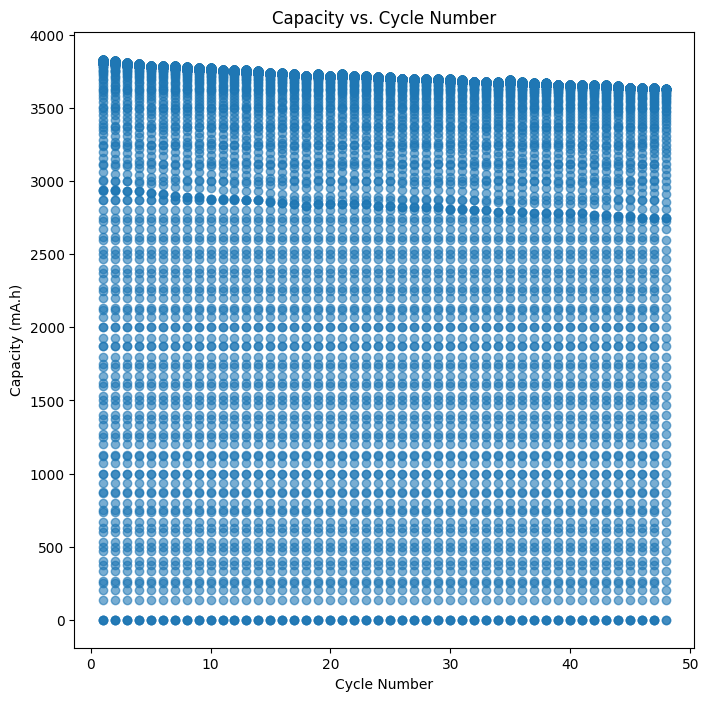

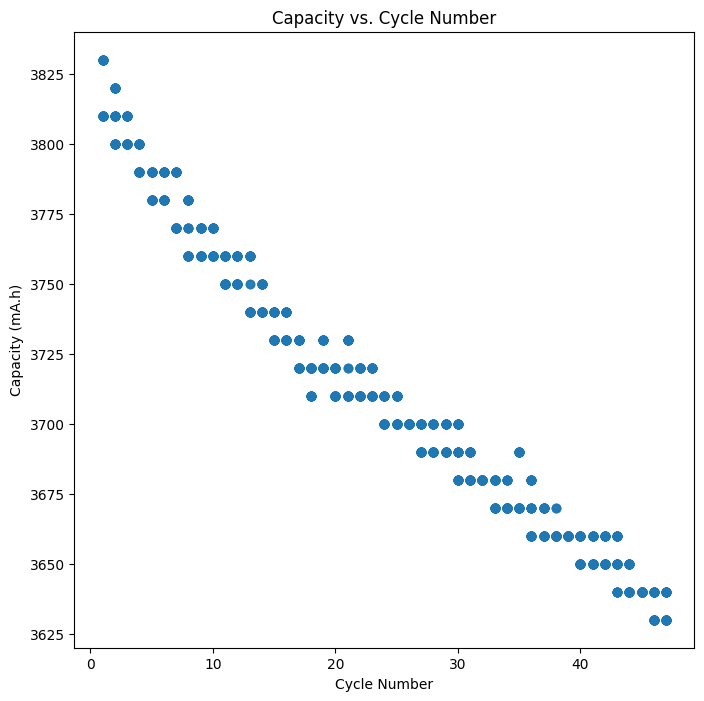

In [6]:
plot_degradation(df)